In [1]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials

import optuna


%matplotlib inline
plt.style.use('seaborn')

In [2]:
data = pd.read_csv('data/_train_sem09.csv')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,...,D1762,D1763,D1764,D1765,D1766,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,0.243144,0.187856,0.0000,0.000000,0.069000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,0.106480,0.101382,0.1875,0.193548,0.131001,...,0,1,1,0,0,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,0.352308,0.193548,0.1250,0.000000,0.068900,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,0.208989,0.000000,0.0000,0.000000,0.145947,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,0.125177,0.532258,0.0000,0.000000,0.094900,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [3]:
X = data.drop(['Activity'], axis=1)
y = data['Activity']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.2)

## Работа с логистической регрессией

In [77]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter = 50)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)
print("accuracy на тестовом наборе: {:.2f}".format(log_reg.score(X_test, y_test)))
y_test_pred = log_reg.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

c:\Users\d3en\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=50)

accuracy на тестовом наборе: 0.75
f1_score на тестовом наборе: 0.78


### <center> **GridSearchCV**

In [6]:
param_grid = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42, #генератор случайных чисел
        max_iter=50 #количество итераций на сходимость
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test, y_test)))
y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: total: 4.36 s
Wall time: 1min 2s


c:\Users\d3en\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=50, random_state=42),
             n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1],
                          'penalty': ['l2', 'none'],
                          'solver': ['lbfgs', 'sag']},
                         {'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1],
                          'penalty': ['l1', 'l2'],
                          'solver': ['liblinear', 'saga']}])

accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'C': 0.3, 'penalty': 'l1', 'solver': 'saga'}


In [7]:
print("Наилучшая модель:\n{}".format(grid_search.best_estimator_))

Наилучшая модель:
LogisticRegression(C=0.3, max_iter=50, penalty='l1', random_state=42,
                   solver='saga')


In [8]:
print("Наилучшее значение точности при кросс-валидаци: {:.2f}".format(grid_search.best_score_))

Наилучшее значение точности при кросс-валидаци: 0.77


## cross_val_score

In [9]:
from sklearn import model_selection
from sklearn.model_selection import KFold

In [10]:
kf = model_selection.KFold(n_splits=5)

In [12]:
score = cross_val_score(log_reg, X, y, cv=kf, scoring="f1", n_jobs=-1).mean()
print("Наилучшее значение точности при кросс-валидаци: {:.2f}".format(score))

Наилучшее значение точности при кросс-валидаци: 0.77


### <center> **RandomizedSearchCV**

In [9]:
param_distributions = {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))},
            
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=50), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(random_search.score(X_test, y_test)))
y_test_pred = random_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

CPU times: total: 2.33 s
Wall time: 16 s


c:\Users\d3en\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(max_iter=50, random_state=42),
                   n_jobs=-1,
                   param_distributions=({'C': [0.01, 0.12, 0.23, 0.34, 0.45,
                                               0.56, 0.67, 0.78, 0.89, 1.0],
                                         'penalty': ['l2', 'none'],
                                         'solver': ['lbfgs', 'sag']},))

accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'solver': 'sag', 'penalty': 'l2', 'C': 0.23}


### <center> Работа со случайным лесом

### <center> Hyperopt

In [43]:
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
       'max_depth' : hp.quniform('max_depth', 15, 26, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }

In [45]:
# зафксируем random_state
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    # score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [46]:
%%time
# начинаем подбор гиперпараметров


trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата(Для версии 0.2.7)
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 20/20 [00:46<00:00,  2.34s/trial, best loss: -0.9868380777471687]
Наилучшие значения гиперпараметров {'max_depth': 18.0, 'min_samples_leaf': 2.0, 'n_estimators': 103.0}
CPU times: total: 43.6 s
Wall time: 46.8 s


In [52]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

RandomForestClassifier(max_depth=18, min_samples_leaf=2, n_estimators=103,
                       random_state=42)

f1_score на обучающем наборе: 0.99
accuracy на тестовом наборе: 0.79
f1_score на тестовом наборе: 0.81


In [53]:
# если необходимо продолжить подбор, 
# то увеличиваем max_evals(должен быть строго больше, чем на предыдуших итерациях) 
# и используем старый trials
best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=23, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 23/23 [00:07<00:00,  2.57s/trial, best loss: -0.9886607416487896]
Наилучшие значения гиперпараметров {'max_depth': 21.0, 'min_samples_leaf': 2.0, 'n_estimators': 101.0}


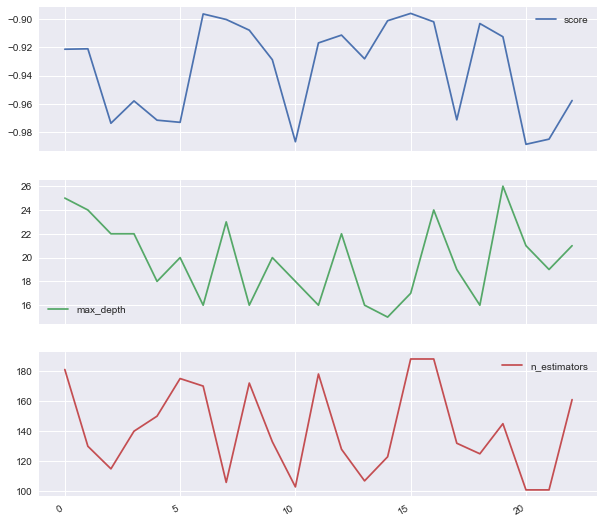

In [54]:
# отрисуем, как менялась точность при различных гиперпараметрах
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['n_estimators'][0]] for x in trials.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'max_depth', 'n_estimators'])
# тепловая карта в данном случае не очень наглядна, возьмем линейный график
tpe_results_df.plot(subplots=True,figsize=(10, 10));

## <center> Optuna

In [56]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score
  
  

In [57]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2022-11-14 17:50:57,889] A new study created in memory with name: RandomForestClassifier
[I 2022-11-14 17:51:00,664] Trial 0 finished with value: 0.959339651482727 and parameters: {'n_estimators': 128, 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.959339651482727.
[I 2022-11-14 17:51:03,600] Trial 1 finished with value: 0.8932395227898441 and parameters: {'n_estimators': 181, 'max_depth': 10, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.959339651482727.
[I 2022-11-14 17:51:06,306] Trial 2 finished with value: 0.9030689759951384 and parameters: {'n_estimators': 166, 'max_depth': 25, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.959339651482727.
[I 2022-11-14 17:51:08,523] Trial 3 finished with value: 0.9029126213592232 and parameters: {'n_estimators': 163, 'max_depth': 29, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.959339651482727.
[I 2022-11-14 17:51:10,909] Trial 4 finished with value: 0.9213005165603161 and parameters: {'n_estim

CPU times: total: 46.9 s
Wall time: 49.3 s


In [58]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 141, 'max_depth': 22, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.99


In [61]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

RandomForestClassifier(max_depth=22, min_samples_leaf=2, n_estimators=141,
                       random_state=42)

accuracy на тестовом наборе: 0.78
f1_score на тестовом наборе: 0.80


In [62]:
%%time
# можем прододжить подбор, указав n_trials(любое число, которое добавится к предыдущим итерациям) 
study.optimize(optuna_rf, n_trials=10)

[I 2022-11-14 17:55:42,768] Trial 20 finished with value: 0.9908031882280809 and parameters: {'n_estimators': 119, 'max_depth': 28, 'min_samples_leaf': 2}. Best is trial 20 with value: 0.9908031882280809.
[I 2022-11-14 17:55:45,067] Trial 21 finished with value: 0.9908031882280809 and parameters: {'n_estimators': 119, 'max_depth': 28, 'min_samples_leaf': 2}. Best is trial 20 with value: 0.9908031882280809.
[I 2022-11-14 17:55:47,018] Trial 22 finished with value: 0.9725106902871106 and parameters: {'n_estimators': 116, 'max_depth': 27, 'min_samples_leaf': 3}. Best is trial 20 with value: 0.9908031882280809.
[I 2022-11-14 17:55:49,305] Trial 23 finished with value: 0.9892670959828274 and parameters: {'n_estimators': 121, 'max_depth': 29, 'min_samples_leaf': 2}. Best is trial 20 with value: 0.9908031882280809.
[I 2022-11-14 17:55:51,261] Trial 24 finished with value: 0.9716203844980166 and parameters: {'n_estimators': 110, 'max_depth': 27, 'min_samples_leaf': 3}. Best is trial 20 with va

CPU times: total: 20.7 s
Wall time: 21.6 s


In [67]:
# Проверяем доступны ли правильные версии plotly и matplotlib для создания визуализаций.

optuna.visualization.is_available()

True

In [64]:
# Строим график истории оптимизации

optuna.visualization.plot_optimization_history(study, target_name="f1_score")

In [65]:
# График важности гиперпараметров

optuna.visualization.plot_param_importances(study, target_name="f1_score")

In [66]:
# График контура отношений гиперпараметров

optuna.visualization.plot_contour(study, params=["max_depth", "n_estimators"],
                                  target_name="f1_score")